## GANs for cell

* using nn-gans for sequential cell type detection
* cell life-cycle detection

### Implement using PyTorch
* genetative adversial networks using nerual networks

In [1]:
%load_ext watermark
%watermark -v -p torch,numpy\

CPython 2.7.6
IPython 5.4.1

torch 0.1.12_2
numpy 1.12.1


In [64]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image
from torch.autograd import Variable
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 9)
plt.rcParams['image.cmap'] = 'gray' 

### params setting

In [3]:
# dataset ='cifar10'
dataroot = './dataset'
# workers
batchSize=32
imageSize=64
nz=100
ngf=64
ndf=64
niter=25
lr=0.002
lrD=0.00005
lrG=0.00005
beta1=0.5
# cuda
ngpu=1
netG=''
netD=''
outf='results'
nc=1
cuda=True
manualSeed=None
# manualSeed=9853
workers=2


lrD=0.00005
lrG=0.00005
_Diters=5
clamp_lower=-0.01
clamp_upper=0.01
experiment='results'
adam=False


In [4]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw ')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netG', default='', help="path to netG (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
# parser.add_argument('--manualSeed', type=int, help='manual seed')

# opt = parser.parse_args()
# print(opt)

In [5]:
try:
    os.makedirs(outf)
except OSError:
    pass

if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if cuda:
    torch.cuda.manual_seed_all(manualSeed)

cudnn.benchmark = False

Random Seed:  4867


### data loading

In [6]:
# # dataset == 'cifar10'
# dataset = dset.CIFAR10(root=dataroot, download=True,
#                        transform=transforms.Compose([
#                            transforms.Scale(imageSize),
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                        ])
# )
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
#                                          shuffle=True, num_workers=int(workers))

In [7]:
trainset = dset.ImageFolder(root='cellcycle/', 
                            transform=transforms.Compose([
                                transforms.Scale(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,shuffle=True, num_workers=2)

print(trainset.class_to_idx)

{'1': 1, '0': 0, '3': 3, '2': 2}


### network definition

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # inputs size 100 random numbers
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=ngf * 8),
            nn.ReLU(True),
            
            # intermediate output size (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ngf * 4),
            nn.ReLU(True),
            
            # inter-output size (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ngf * 2),
            nn.ReLU(True),
            
            # inter-output size (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # inter-output size (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # output size (nc) x 64 x 64
        )
    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output



class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.interm = None
        self.main = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=nc*64*64, out_channels=nc, kernel_size=64,
#                                stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(num_features=nc),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.ReLU(True),
            
            # input size (nc) x 64 x 64
            
#             nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=16,
#                                stride=2, padding=0, bias=False),
#             nn.BatchNorm2d(num_features=nc),
#             nn.ReLU(True),
            
            # input size (nc) x 64 x 64
            nn.Conv2d(in_channels=nc+1, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # inter-output size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, 
                      stride=1, padding=0, bias=False),
#             nn.Linear(256, 1),
            nn.Sigmoid()            ######################### drop the final sigmoid function
            # output 1 x ? x ?
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
#             _output = _output.view(_output.size(0), -1)
#             output = self.classifier(_output)
            self.interm = output
#         output = output.mean(0)
        return output.view(1, -1)

* print networks

In [9]:
netG = _netG(ngpu)
netG.apply(weights_init)
print(netG)

netD = _netD(ngpu)
netD.apply(weights_init)

print(netD)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
_netD (
  (main): Sequential (
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

### Define Optimizer

In [10]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
label_channel = torch.FloatTensor(batchSize, nc, imageSize, imageSize).normal_(0, 1)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

if cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    label_channel = label_channel.cuda()

fixed_noise = Variable(fixed_noise)
label_channel = Variable(label_channel)
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
# optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

### Start Training

* learn the distribution of healthy cells

In [11]:
dataloader = trainloader

In [13]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        #real_cpu, _ = data
        real_cpu = data[0][:,:1,:,:]
        real_groundtruth = data[1]
        batch_size = real_cpu.size(0)
        if cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        
        labelv = Variable(label)

        
        #################   self add   ###################
#         inputv = inputv.view(inputv.size(0), -1)
#         inputv = inputv.resize(inputv.size(0), inputv.size(1), 1, 1)
        label_channel_temp = torch.FloatTensor(inputv.size(0), nc, imageSize, imageSize)
        for j in xrange(len(real_groundtruth)):
            label_channel_temp[j] = real_groundtruth[j]
        label_channel_temp = Variable(label_channel_temp.cuda())
        inputv_temp = torch.cat([inputv, label_channel_temp], dim=1)
        inputv = inputv_temp
        ##################################################
        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        #################   self add   ###################
#         fake = fake.view(fake.size(0), -1)
#         fake = fake.resize(fake.size(0), fake.size(1), 1, 1)
        label_channel_temp = torch.FloatTensor(fake.size(0), nc, imageSize, imageSize)
        for j in xrange(len(real_groundtruth)):
            label_channel_temp[j] = real_groundtruth[j]
        label_channel_temp = Variable(label_channel_temp.cuda())
        fake_temp = torch.cat([fake, label_channel_temp], dim=1)
        fake = fake_temp
        ##################################################
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


[0/25][0/61] Loss_D: 1.6431 Loss_G: 11.2313 D(x): 0.6384 D(G(z)): 0.6397 / 0.2810
[0/25][1/61] Loss_D: 10.1551 Loss_G: 10.0026 D(x): 0.3443 D(G(z)): 0.3437 / 0.5938
[0/25][2/61] Loss_D: 19.3675 Loss_G: 5.9759 D(x): 0.6379 D(G(z)): 0.5059 / 0.7811
[0/25][3/61] Loss_D: 14.6858 Loss_G: 7.2155 D(x): 0.8437 D(G(z)): 0.8365 / 0.0330
[0/25][4/61] Loss_D: 8.1031 Loss_G: 1.7979 D(x): 0.2368 D(G(z)): 0.0898 / 0.1923
[0/25][5/61] Loss_D: 1.0069 Loss_G: 0.9888 D(x): 0.5749 D(G(z)): 0.2729 / 0.4616
[0/25][6/61] Loss_D: 4.3513 Loss_G: 0.5638 D(x): 0.8018 D(G(z)): 0.5543 / 0.6104
[0/25][7/61] Loss_D: 3.5946 Loss_G: 2.5370 D(x): 0.8867 D(G(z)): 0.7151 / 0.1730
[0/25][8/61] Loss_D: 1.6797 Loss_G: 2.2186 D(x): 0.5306 D(G(z)): 0.3002 / 0.2491
[0/25][9/61] Loss_D: 1.9482 Loss_G: 2.3007 D(x): 0.4045 D(G(z)): 0.3187 / 0.5480
[0/25][10/61] Loss_D: 3.7798 Loss_G: 1.4057 D(x): 0.7883 D(G(z)): 0.7016 / 0.3377
[0/25][11/61] Loss_D: 1.2918 Loss_G: 2.0573 D(x): 0.5610 D(G(z)): 0.3936 / 0.1947
[0/25][12/61] Loss_D:

[1/25][40/61] Loss_D: 2.2878 Loss_G: 1.8367 D(x): 0.3637 D(G(z)): 0.3552 / 0.4455
[1/25][41/61] Loss_D: 2.0379 Loss_G: 1.7540 D(x): 0.5883 D(G(z)): 0.5572 / 0.2147
[1/25][42/61] Loss_D: 1.3355 Loss_G: 1.1233 D(x): 0.4381 D(G(z)): 0.2854 / 0.4140
[1/25][43/61] Loss_D: 1.2970 Loss_G: 1.9734 D(x): 0.7790 D(G(z)): 0.5522 / 0.2259
[1/25][44/61] Loss_D: 1.5595 Loss_G: 1.2977 D(x): 0.3959 D(G(z)): 0.2466 / 0.3598
[1/25][45/61] Loss_D: 1.4154 Loss_G: 2.4980 D(x): 0.8292 D(G(z)): 0.5938 / 0.1096
[1/25][46/61] Loss_D: 1.2812 Loss_G: 2.2948 D(x): 0.4402 D(G(z)): 0.2170 / 0.3030
[1/25][47/61] Loss_D: 2.2143 Loss_G: 2.4474 D(x): 0.7345 D(G(z)): 0.6733 / 0.1834
[1/25][48/61] Loss_D: 1.9455 Loss_G: 2.7058 D(x): 0.4015 D(G(z)): 0.2900 / 0.1683
[1/25][49/61] Loss_D: 1.9272 Loss_G: 0.5684 D(x): 0.4397 D(G(z)): 0.2886 / 0.6339
[1/25][50/61] Loss_D: 2.3164 Loss_G: 1.3854 D(x): 0.8008 D(G(z)): 0.7067 / 0.2638
[1/25][51/61] Loss_D: 1.1992 Loss_G: 1.4425 D(x): 0.5087 D(G(z)): 0.3762 / 0.2636
[1/25][52/61] Lo

[3/25][19/61] Loss_D: 1.1982 Loss_G: 1.1312 D(x): 0.5161 D(G(z)): 0.2191 / 0.4577
[3/25][20/61] Loss_D: 2.2881 Loss_G: 2.9786 D(x): 0.8289 D(G(z)): 0.7466 / 0.0720
[3/25][21/61] Loss_D: 1.6205 Loss_G: 1.5712 D(x): 0.2706 D(G(z)): 0.1557 / 0.2737
[3/25][22/61] Loss_D: 1.1965 Loss_G: 0.8490 D(x): 0.4789 D(G(z)): 0.2827 / 0.4605
[3/25][23/61] Loss_D: 1.5505 Loss_G: 2.2779 D(x): 0.8301 D(G(z)): 0.7095 / 0.1298
[3/25][24/61] Loss_D: 1.2792 Loss_G: 1.4246 D(x): 0.3989 D(G(z)): 0.1934 / 0.2718
[3/25][25/61] Loss_D: 0.9446 Loss_G: 1.7368 D(x): 0.7401 D(G(z)): 0.4051 / 0.2743
[3/25][26/61] Loss_D: 1.1939 Loss_G: 2.4212 D(x): 0.7250 D(G(z)): 0.3588 / 0.2536
[3/25][27/61] Loss_D: 1.2674 Loss_G: 1.6293 D(x): 0.5830 D(G(z)): 0.3030 / 0.2813
[3/25][28/61] Loss_D: 1.0134 Loss_G: 3.0528 D(x): 0.8112 D(G(z)): 0.4124 / 0.1087
[3/25][29/61] Loss_D: 1.1849 Loss_G: 1.5306 D(x): 0.5262 D(G(z)): 0.1952 / 0.2468
[3/25][30/61] Loss_D: 1.5578 Loss_G: 2.5876 D(x): 0.7759 D(G(z)): 0.6114 / 0.1366
[3/25][31/61] Lo

[4/25][60/61] Loss_D: 0.8526 Loss_G: 2.2977 D(x): 0.7037 D(G(z)): 0.3550 / 0.3196
[5/25][0/61] Loss_D: 2.0271 Loss_G: 1.6254 D(x): 0.6237 D(G(z)): 0.5383 / 0.2848
[5/25][1/61] Loss_D: 1.4499 Loss_G: 1.6276 D(x): 0.5254 D(G(z)): 0.4032 / 0.4127
[5/25][2/61] Loss_D: 1.3809 Loss_G: 1.6726 D(x): 0.6739 D(G(z)): 0.5350 / 0.2050
[5/25][3/61] Loss_D: 1.2094 Loss_G: 2.0526 D(x): 0.5377 D(G(z)): 0.3344 / 0.2776
[5/25][4/61] Loss_D: 0.8769 Loss_G: 2.5039 D(x): 0.7661 D(G(z)): 0.3920 / 0.1313
[5/25][5/61] Loss_D: 1.5432 Loss_G: 1.5408 D(x): 0.5997 D(G(z)): 0.3815 / 0.3046
[5/25][6/61] Loss_D: 1.9577 Loss_G: 2.1785 D(x): 0.5416 D(G(z)): 0.4360 / 0.2250
[5/25][7/61] Loss_D: 1.6026 Loss_G: 1.9794 D(x): 0.6027 D(G(z)): 0.3515 / 0.3005
[5/25][8/61] Loss_D: 1.4364 Loss_G: 1.4743 D(x): 0.5739 D(G(z)): 0.4056 / 0.2986
[5/25][9/61] Loss_D: 1.4077 Loss_G: 2.1045 D(x): 0.6097 D(G(z)): 0.4660 / 0.2372
[5/25][10/61] Loss_D: 1.8360 Loss_G: 1.7230 D(x): 0.4492 D(G(z)): 0.3219 / 0.5268
[5/25][11/61] Loss_D: 2.50

[6/25][39/61] Loss_D: 1.4106 Loss_G: 2.3739 D(x): 0.7792 D(G(z)): 0.5976 / 0.1174
[6/25][40/61] Loss_D: 1.3051 Loss_G: 1.8035 D(x): 0.4854 D(G(z)): 0.2286 / 0.2158
[6/25][41/61] Loss_D: 1.0542 Loss_G: 1.2401 D(x): 0.5837 D(G(z)): 0.2984 / 0.3801
[6/25][42/61] Loss_D: 1.4946 Loss_G: 2.4161 D(x): 0.8323 D(G(z)): 0.6117 / 0.1172
[6/25][43/61] Loss_D: 1.1728 Loss_G: 1.7430 D(x): 0.5157 D(G(z)): 0.2461 / 0.2179
[6/25][44/61] Loss_D: 1.1615 Loss_G: 1.1934 D(x): 0.5620 D(G(z)): 0.3221 / 0.3333
[6/25][45/61] Loss_D: 1.5614 Loss_G: 2.0781 D(x): 0.7761 D(G(z)): 0.6770 / 0.1578
[6/25][46/61] Loss_D: 1.2917 Loss_G: 1.3976 D(x): 0.4227 D(G(z)): 0.2112 / 0.2808
[6/25][47/61] Loss_D: 1.1176 Loss_G: 1.0956 D(x): 0.6076 D(G(z)): 0.4039 / 0.3520
[6/25][48/61] Loss_D: 1.2473 Loss_G: 2.1942 D(x): 0.7718 D(G(z)): 0.5738 / 0.1318
[6/25][49/61] Loss_D: 1.2963 Loss_G: 1.2881 D(x): 0.4485 D(G(z)): 0.1651 / 0.3577
[6/25][50/61] Loss_D: 1.3577 Loss_G: 1.0609 D(x): 0.6485 D(G(z)): 0.4742 / 0.3914
[6/25][51/61] Lo

[8/25][18/61] Loss_D: 1.4841 Loss_G: 2.2150 D(x): 0.6240 D(G(z)): 0.3900 / 0.3177
[8/25][19/61] Loss_D: 1.3274 Loss_G: 1.7361 D(x): 0.6947 D(G(z)): 0.3578 / 0.2056
[8/25][20/61] Loss_D: 1.0699 Loss_G: 2.3547 D(x): 0.7062 D(G(z)): 0.4216 / 0.1958
[8/25][21/61] Loss_D: 1.1940 Loss_G: 1.3744 D(x): 0.5426 D(G(z)): 0.2376 / 0.3098
[8/25][22/61] Loss_D: 1.1932 Loss_G: 2.3359 D(x): 0.8336 D(G(z)): 0.5677 / 0.1042
[8/25][23/61] Loss_D: 1.0393 Loss_G: 1.6322 D(x): 0.5080 D(G(z)): 0.1488 / 0.2237
[8/25][24/61] Loss_D: 0.9341 Loss_G: 2.3164 D(x): 0.8278 D(G(z)): 0.4760 / 0.1046
[8/25][25/61] Loss_D: 0.9958 Loss_G: 1.7307 D(x): 0.5550 D(G(z)): 0.2871 / 0.2059
[8/25][26/61] Loss_D: 1.1370 Loss_G: 1.4118 D(x): 0.6014 D(G(z)): 0.2486 / 0.2941
[8/25][27/61] Loss_D: 1.5164 Loss_G: 2.0989 D(x): 0.8278 D(G(z)): 0.6814 / 0.1473
[8/25][28/61] Loss_D: 1.1851 Loss_G: 1.4852 D(x): 0.4218 D(G(z)): 0.0955 / 0.3817
[8/25][29/61] Loss_D: 1.1284 Loss_G: 2.2598 D(x): 0.8707 D(G(z)): 0.5715 / 0.1238
[8/25][30/61] Lo

[9/25][58/61] Loss_D: 0.9752 Loss_G: 4.5402 D(x): 0.8571 D(G(z)): 0.4790 / 0.0142
[9/25][59/61] Loss_D: 1.2380 Loss_G: 2.5178 D(x): 0.4873 D(G(z)): 0.0409 / 0.3461
[9/25][60/61] Loss_D: 1.2665 Loss_G: 15.3444 D(x): 0.6300 D(G(z)): 0.3767 / 0.0000
[10/25][0/61] Loss_D: 0.5327 Loss_G: 4.4083 D(x): 0.7655 D(G(z)): 0.0772 / 0.0456
[10/25][1/61] Loss_D: 0.2391 Loss_G: 4.0423 D(x): 0.9167 D(G(z)): 0.1027 / 0.0296
[10/25][2/61] Loss_D: 0.5269 Loss_G: 2.9540 D(x): 0.8335 D(G(z)): 0.1513 / 0.1358
[10/25][3/61] Loss_D: 0.4465 Loss_G: 3.5655 D(x): 0.9528 D(G(z)): 0.2600 / 0.0472
[10/25][4/61] Loss_D: 0.3451 Loss_G: 3.8824 D(x): 0.9116 D(G(z)): 0.1887 / 0.0385
[10/25][5/61] Loss_D: 0.4365 Loss_G: 3.9376 D(x): 0.9171 D(G(z)): 0.2145 / 0.0309
[10/25][6/61] Loss_D: 0.1894 Loss_G: 4.2544 D(x): 0.9366 D(G(z)): 0.1012 / 0.0298
[10/25][7/61] Loss_D: 0.2513 Loss_G: 4.1065 D(x): 0.8959 D(G(z)): 0.0876 / 0.0409
[10/25][8/61] Loss_D: 0.1023 Loss_G: 4.8290 D(x): 0.9627 D(G(z)): 0.0392 / 0.0190
[10/25][9/61] L

[11/25][35/61] Loss_D: 1.6483 Loss_G: 1.8644 D(x): 0.7658 D(G(z)): 0.5794 / 0.1894
[11/25][36/61] Loss_D: 1.0839 Loss_G: 2.0976 D(x): 0.5883 D(G(z)): 0.3037 / 0.1613
[11/25][37/61] Loss_D: 1.0727 Loss_G: 1.5886 D(x): 0.5738 D(G(z)): 0.2816 / 0.2492
[11/25][38/61] Loss_D: 0.9610 Loss_G: 1.8723 D(x): 0.6593 D(G(z)): 0.3385 / 0.2285
[11/25][39/61] Loss_D: 0.7538 Loss_G: 2.8482 D(x): 0.7859 D(G(z)): 0.3018 / 0.0920
[11/25][40/61] Loss_D: 0.8523 Loss_G: 2.4991 D(x): 0.7065 D(G(z)): 0.2850 / 0.1589
[11/25][41/61] Loss_D: 0.7254 Loss_G: 2.2953 D(x): 0.7339 D(G(z)): 0.2442 / 0.1373
[11/25][42/61] Loss_D: 1.1857 Loss_G: 3.4076 D(x): 0.8021 D(G(z)): 0.5181 / 0.0953
[11/25][43/61] Loss_D: 1.7536 Loss_G: 1.8046 D(x): 0.3823 D(G(z)): 0.1716 / 0.1961
[11/25][44/61] Loss_D: 1.0964 Loss_G: 1.2934 D(x): 0.5813 D(G(z)): 0.2504 / 0.3034
[11/25][45/61] Loss_D: 1.0252 Loss_G: 2.6655 D(x): 0.8449 D(G(z)): 0.5125 / 0.0969
[11/25][46/61] Loss_D: 0.9652 Loss_G: 2.5288 D(x): 0.6333 D(G(z)): 0.1694 / 0.1026
[11/

[13/25][12/61] Loss_D: 1.1749 Loss_G: 4.1963 D(x): 0.8796 D(G(z)): 0.5664 / 0.0357
[13/25][13/61] Loss_D: 1.1628 Loss_G: 2.2016 D(x): 0.4866 D(G(z)): 0.1169 / 0.1368
[13/25][14/61] Loss_D: 0.9071 Loss_G: 2.6936 D(x): 0.7731 D(G(z)): 0.3872 / 0.1469
[13/25][15/61] Loss_D: 0.7279 Loss_G: 2.9018 D(x): 0.7120 D(G(z)): 0.1807 / 0.0842
[13/25][16/61] Loss_D: 0.9946 Loss_G: 2.9865 D(x): 0.7227 D(G(z)): 0.3874 / 0.1027
[13/25][17/61] Loss_D: 0.6312 Loss_G: 2.7892 D(x): 0.7349 D(G(z)): 0.1255 / 0.1290
[13/25][18/61] Loss_D: 0.9688 Loss_G: 5.1300 D(x): 0.8131 D(G(z)): 0.4486 / 0.0084
[13/25][19/61] Loss_D: 1.4729 Loss_G: 1.3191 D(x): 0.4376 D(G(z)): 0.0413 / 0.3400
[13/25][20/61] Loss_D: 1.7260 Loss_G: 3.7959 D(x): 0.7953 D(G(z)): 0.6773 / 0.1005
[13/25][21/61] Loss_D: 1.6461 Loss_G: 2.8953 D(x): 0.4005 D(G(z)): 0.1239 / 0.1557
[13/25][22/61] Loss_D: 1.4823 Loss_G: 2.1089 D(x): 0.6270 D(G(z)): 0.2864 / 0.1742
[13/25][23/61] Loss_D: 0.7573 Loss_G: 2.7915 D(x): 0.8549 D(G(z)): 0.3826 / 0.0919
[13/

[14/25][50/61] Loss_D: 0.9862 Loss_G: 4.5837 D(x): 0.8463 D(G(z)): 0.4352 / 0.0337
[14/25][51/61] Loss_D: 1.0982 Loss_G: 3.5015 D(x): 0.6033 D(G(z)): 0.1138 / 0.0473
[14/25][52/61] Loss_D: 0.7137 Loss_G: 2.5575 D(x): 0.7534 D(G(z)): 0.1714 / 0.2200
[14/25][53/61] Loss_D: 1.6902 Loss_G: 4.0352 D(x): 0.7489 D(G(z)): 0.4672 / 0.0676
[14/25][54/61] Loss_D: 0.8697 Loss_G: 5.8470 D(x): 0.7790 D(G(z)): 0.3212 / 0.0063
[14/25][55/61] Loss_D: 1.3595 Loss_G: 1.6534 D(x): 0.4434 D(G(z)): 0.0895 / 0.2480
[14/25][56/61] Loss_D: 1.1914 Loss_G: 2.3753 D(x): 0.8013 D(G(z)): 0.4938 / 0.1461
[14/25][57/61] Loss_D: 0.9173 Loss_G: 2.7817 D(x): 0.7150 D(G(z)): 0.3045 / 0.1717
[14/25][58/61] Loss_D: 1.2605 Loss_G: 3.3755 D(x): 0.7411 D(G(z)): 0.3662 / 0.0717
[14/25][59/61] Loss_D: 0.8968 Loss_G: 2.5571 D(x): 0.7311 D(G(z)): 0.3420 / 0.1522
[14/25][60/61] Loss_D: 2.5815 Loss_G: 3.4242 D(x): 0.3957 D(G(z)): 0.4890 / 0.0912
[15/25][0/61] Loss_D: 1.4233 Loss_G: 3.1104 D(x): 0.9200 D(G(z)): 0.5702 / 0.1308
[15/2

[16/25][27/61] Loss_D: 0.6948 Loss_G: 3.0057 D(x): 0.7428 D(G(z)): 0.2358 / 0.1209
[16/25][28/61] Loss_D: 1.0783 Loss_G: 3.1791 D(x): 0.6842 D(G(z)): 0.3162 / 0.1293
[16/25][29/61] Loss_D: 0.9733 Loss_G: 4.6713 D(x): 0.8175 D(G(z)): 0.3349 / 0.0256
[16/25][30/61] Loss_D: 0.6971 Loss_G: 3.0232 D(x): 0.7045 D(G(z)): 0.0990 / 0.1136
[16/25][31/61] Loss_D: 1.4208 Loss_G: 5.8939 D(x): 0.8900 D(G(z)): 0.6585 / 0.0078
[16/25][32/61] Loss_D: 2.3823 Loss_G: 1.7822 D(x): 0.1986 D(G(z)): 0.0094 / 0.1906
[16/25][33/61] Loss_D: 0.9491 Loss_G: 2.2085 D(x): 0.8481 D(G(z)): 0.4544 / 0.2512
[16/25][34/61] Loss_D: 0.9451 Loss_G: 2.3920 D(x): 0.8850 D(G(z)): 0.4766 / 0.1108
[16/25][35/61] Loss_D: 0.7695 Loss_G: 2.8964 D(x): 0.5644 D(G(z)): 0.0541 / 0.1176
[16/25][36/61] Loss_D: 1.1683 Loss_G: 2.3065 D(x): 0.8462 D(G(z)): 0.5134 / 0.1646
[16/25][37/61] Loss_D: 0.7591 Loss_G: 2.8916 D(x): 0.7301 D(G(z)): 0.2697 / 0.0787
[16/25][38/61] Loss_D: 0.6577 Loss_G: 2.7736 D(x): 0.7668 D(G(z)): 0.1875 / 0.0962
[16/

[18/25][4/61] Loss_D: 0.9060 Loss_G: 2.7972 D(x): 0.6760 D(G(z)): 0.2348 / 0.1192
[18/25][5/61] Loss_D: 0.6318 Loss_G: 2.7172 D(x): 0.7925 D(G(z)): 0.2462 / 0.1064
[18/25][6/61] Loss_D: 1.0338 Loss_G: 2.1857 D(x): 0.6818 D(G(z)): 0.3199 / 0.1574
[18/25][7/61] Loss_D: 1.4055 Loss_G: 2.7056 D(x): 0.6553 D(G(z)): 0.4643 / 0.1547
[18/25][8/61] Loss_D: 0.8740 Loss_G: 3.4350 D(x): 0.7338 D(G(z)): 0.2640 / 0.0478
[18/25][9/61] Loss_D: 0.7861 Loss_G: 2.2551 D(x): 0.6433 D(G(z)): 0.1795 / 0.1884
[18/25][10/61] Loss_D: 0.9107 Loss_G: 2.2227 D(x): 0.7307 D(G(z)): 0.3395 / 0.1624
[18/25][11/61] Loss_D: 0.7356 Loss_G: 2.2301 D(x): 0.7003 D(G(z)): 0.1989 / 0.1569
[18/25][12/61] Loss_D: 0.9026 Loss_G: 3.2490 D(x): 0.8628 D(G(z)): 0.4747 / 0.0473
[18/25][13/61] Loss_D: 0.6827 Loss_G: 2.6752 D(x): 0.6716 D(G(z)): 0.2077 / 0.0919
[18/25][14/61] Loss_D: 0.6599 Loss_G: 2.6455 D(x): 0.7723 D(G(z)): 0.2368 / 0.1310
[18/25][15/61] Loss_D: 0.5836 Loss_G: 3.2718 D(x): 0.7869 D(G(z)): 0.1800 / 0.0582
[18/25][16

[19/25][42/61] Loss_D: 0.1276 Loss_G: 4.7801 D(x): 0.9028 D(G(z)): 0.0073 / 0.0342
[19/25][43/61] Loss_D: 0.6431 Loss_G: 3.0710 D(x): 0.9524 D(G(z)): 0.4074 / 0.0644
[19/25][44/61] Loss_D: 0.5925 Loss_G: 4.4320 D(x): 0.8186 D(G(z)): 0.2415 / 0.0306
[19/25][45/61] Loss_D: 0.3467 Loss_G: 4.2767 D(x): 0.8534 D(G(z)): 0.1432 / 0.0249
[19/25][46/61] Loss_D: 0.6743 Loss_G: 3.1248 D(x): 0.7250 D(G(z)): 0.1540 / 0.0793
[19/25][47/61] Loss_D: 0.4827 Loss_G: 3.6026 D(x): 0.8750 D(G(z)): 0.2181 / 0.0364
[19/25][48/61] Loss_D: 0.7282 Loss_G: 2.9332 D(x): 0.7215 D(G(z)): 0.1952 / 0.0946
[19/25][49/61] Loss_D: 0.6702 Loss_G: 3.5335 D(x): 0.7853 D(G(z)): 0.2093 / 0.0836
[19/25][50/61] Loss_D: 1.8262 Loss_G: 3.9952 D(x): 0.4981 D(G(z)): 0.3402 / 0.1183
[19/25][51/61] Loss_D: 1.4404 Loss_G: 2.5183 D(x): 0.6075 D(G(z)): 0.1687 / 0.2890
[19/25][52/61] Loss_D: 1.3615 Loss_G: 5.4295 D(x): 0.9939 D(G(z)): 0.5384 / 0.0087
[19/25][53/61] Loss_D: 0.6161 Loss_G: 3.6949 D(x): 0.6962 D(G(z)): 0.1148 / 0.0496
[19/

[21/25][19/61] Loss_D: 0.5740 Loss_G: 3.9335 D(x): 0.8731 D(G(z)): 0.2892 / 0.0568
[21/25][20/61] Loss_D: 1.0668 Loss_G: 6.1064 D(x): 0.9764 D(G(z)): 0.5214 / 0.0085
[21/25][21/61] Loss_D: 1.9290 Loss_G: 4.2420 D(x): 0.3191 D(G(z)): 0.0143 / 0.0324
[21/25][22/61] Loss_D: 0.1004 Loss_G: 3.4160 D(x): 0.9480 D(G(z)): 0.0363 / 0.0694
[21/25][23/61] Loss_D: 0.2419 Loss_G: 2.9201 D(x): 0.8837 D(G(z)): 0.0770 / 0.1120
[21/25][24/61] Loss_D: 0.3014 Loss_G: 3.1494 D(x): 0.9734 D(G(z)): 0.2229 / 0.0612
[21/25][25/61] Loss_D: 0.6793 Loss_G: 4.9479 D(x): 0.9333 D(G(z)): 0.3965 / 0.0134
[21/25][26/61] Loss_D: 0.5635 Loss_G: 3.8679 D(x): 0.6853 D(G(z)): 0.0406 / 0.1063
[21/25][27/61] Loss_D: 0.5830 Loss_G: 3.2139 D(x): 0.6875 D(G(z)): 0.0574 / 0.1073
[21/25][28/61] Loss_D: 1.2825 Loss_G: 5.1859 D(x): 0.9070 D(G(z)): 0.6104 / 0.0098
[21/25][29/61] Loss_D: 0.0932 Loss_G: 6.4333 D(x): 0.9305 D(G(z)): 0.0143 / 0.0031
[21/25][30/61] Loss_D: 0.4804 Loss_G: 3.9134 D(x): 0.6904 D(G(z)): 0.0282 / 0.0598
[21/

[22/25][57/61] Loss_D: 1.1945 Loss_G: 1.7051 D(x): 0.4406 D(G(z)): 0.0457 / 0.2399
[22/25][58/61] Loss_D: 0.4272 Loss_G: 1.4724 D(x): 0.7572 D(G(z)): 0.1075 / 0.3104
[22/25][59/61] Loss_D: 0.8229 Loss_G: 5.1039 D(x): 0.9938 D(G(z)): 0.4632 / 0.0288
[22/25][60/61] Loss_D: 1.2195 Loss_G: 2.8655 D(x): 0.4576 D(G(z)): 0.1060 / 0.5510
[23/25][0/61] Loss_D: 1.4825 Loss_G: 4.4468 D(x): 0.8799 D(G(z)): 0.5478 / 0.0453
[23/25][1/61] Loss_D: 0.1429 Loss_G: 6.2974 D(x): 0.9637 D(G(z)): 0.0781 / 0.0223
[23/25][2/61] Loss_D: 0.7493 Loss_G: 5.4922 D(x): 0.6165 D(G(z)): 0.0091 / 0.0364
[23/25][3/61] Loss_D: 0.4621 Loss_G: 4.9317 D(x): 0.9117 D(G(z)): 0.2279 / 0.0392
[23/25][4/61] Loss_D: 0.1940 Loss_G: 5.0463 D(x): 0.8671 D(G(z)): 0.0266 / 0.0317
[23/25][5/61] Loss_D: 0.3683 Loss_G: 4.1256 D(x): 0.9423 D(G(z)): 0.2135 / 0.0252
[23/25][6/61] Loss_D: 0.1096 Loss_G: 4.3835 D(x): 0.9323 D(G(z)): 0.0339 / 0.0425
[23/25][7/61] Loss_D: 0.1626 Loss_G: 3.7521 D(x): 0.9131 D(G(z)): 0.0612 / 0.0381
[23/25][8/61

[24/25][34/61] Loss_D: 0.5225 Loss_G: 6.2454 D(x): 0.8908 D(G(z)): 0.2645 / 0.0147
[24/25][35/61] Loss_D: 0.7390 Loss_G: 5.9961 D(x): 0.6549 D(G(z)): 0.0419 / 0.0104
[24/25][36/61] Loss_D: 0.7571 Loss_G: 2.8476 D(x): 0.7106 D(G(z)): 0.1723 / 0.2596
[24/25][37/61] Loss_D: 0.1664 Loss_G: 4.8900 D(x): 0.9407 D(G(z)): 0.0816 / 0.0464
[24/25][38/61] Loss_D: 0.6985 Loss_G: 5.5031 D(x): 0.9912 D(G(z)): 0.3805 / 0.0239
[24/25][39/61] Loss_D: 0.1444 Loss_G: 6.2977 D(x): 0.9313 D(G(z)): 0.0617 / 0.0123
[24/25][40/61] Loss_D: 0.8931 Loss_G: 4.3720 D(x): 0.5304 D(G(z)): 0.0507 / 0.0401
[24/25][41/61] Loss_D: 0.1182 Loss_G: 3.6186 D(x): 0.9823 D(G(z)): 0.0862 / 0.0693
[24/25][42/61] Loss_D: 0.2824 Loss_G: 4.0950 D(x): 0.9618 D(G(z)): 0.1595 / 0.0273
[24/25][43/61] Loss_D: 0.2453 Loss_G: 5.4197 D(x): 0.9833 D(G(z)): 0.1846 / 0.0092
[24/25][44/61] Loss_D: 0.2391 Loss_G: 4.7438 D(x): 0.8876 D(G(z)): 0.0863 / 0.0208
[24/25][45/61] Loss_D: 0.7069 Loss_G: 5.4749 D(x): 0.5616 D(G(z)): 0.0006 / 0.0103
[24/

### Image interpolation

In [14]:
model_path = 'results/netG_epoch_24.pth'
netG = _netG(ngpu=1) # ngpu, nz, nc, ngf, n_extra_layers
netG.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
netG.cuda()
print()

In [15]:
def convert_img(img_tensor, nrow):
    img_tensor = img_tensor.cpu()
    grid = vutils.make_grid(img_tensor, nrow=nrow, padding=2)
    ndarr = grid.mul(0.5).add(0.5).mul(255).byte().transpose(0, 2).transpose(0, 1).numpy()
    im = Image.fromarray(ndarr)
    return im

In [16]:
generated_data = netG(fixed_noise)

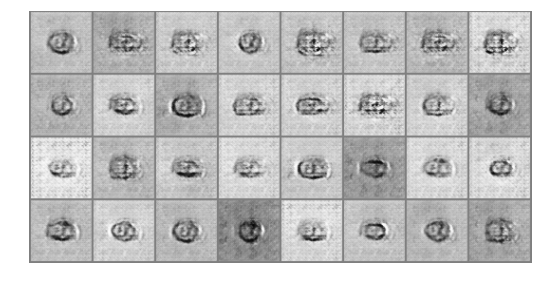

In [108]:
plt.imshow(convert_img(generated_data.data, 8))
plt.axis('off')
plt.show()

### random generated cell images

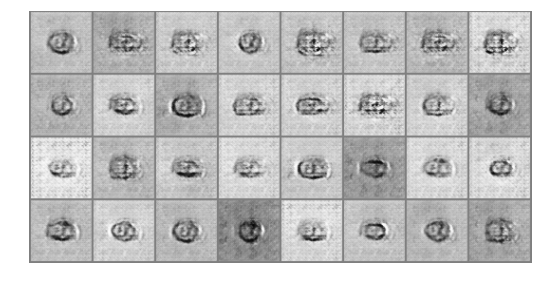

In [77]:
random_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
random_noise = Variable(random_noise.cuda())
generated_data = netG(random_noise)
plt.imshow(convert_img(generated_data.data, 8))
plt.axis('off')
plt.show()

### real cell images

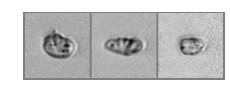

In [72]:
plt.figure(figsize=(3.6,3.6))
plt.imshow(convert_img(real_cpu, 6))
plt.axis('off')
plt.show()

### cell cycle process prediction and visualization

* G1 phase -> S phase

In [102]:
data1 = fixed_noise.data[8]
data_end = fixed_noise.data[22]

d_data = (data_end - data1)/7.
z = torch.FloatTensor(8, 100, 1, 1)

for i in range(8):
    z[i:(i+1),:,:,:] = data1 + i*d_data

In [103]:
from PIL import Image

z = Variable(z.cuda())
z_out = netG(z)
z_im = convert_img(z_out.data,8)

*  predicting the shape changing from G1 to S

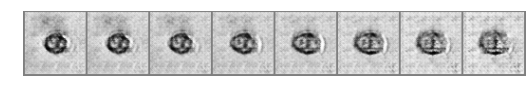

In [104]:
plt.imshow(z_im)
plt.axis('off')
plt.show()

* predicting the shape changing from S to someplace close G2/M

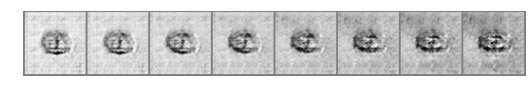

In [120]:
data1 = fixed_noise.data[22]
data_end = fixed_noise.data[2]

d_data = (data_end - data1)/7.
z = torch.FloatTensor(8, 100, 1, 1)

for i in range(8):
    z[i:(i+1),:,:,:] = data1 + i*d_data

# from PIL import Image

z = Variable(z.cuda())
z_out = netG(z)
z_im = convert_img(z_out.data,8)

plt.imshow(z_im)
plt.axis('off')
plt.show()